# Demo: Building Autoencoders in Pytorch

Adapted from: https://github.com/eugeniaring/Medium-Articles/blob/main/Pytorch/denAE.ipynb

By: Jacob Cybulski<br>
Date: July 2023<br>
Comment: *Lots of bugs fixed, works with Torch 2, on both CPU and GPU*

Adapted From: Eugenia Anello, Denoising Autoencoder in Pytorch on MNIST dataset, Dataseries (Medium)<br>
Date: Jun 28, 2021

In [1]:
!pip list | grep torch

torch                         2.0.1+cpu
torchaudio                    2.0.2+cpu
torchsummary                  1.5.1
torchvision                   0.15.2+cpu


In [2]:
import matplotlib.pyplot as plt
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
from torchsummary import summary
import torch.nn.functional as F
import torch.optim as optim
from sklearn.manifold import TSNE

## Prelims: Get data and create tensor data loaders

In [3]:
data_dir = 'dataset'
train_dataset = torchvision.datasets.CIFAR10(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.CIFAR10(data_dir, train=False, download=True)

print('Training data shape:', train_dataset.data.shape)
print('Test data shape:', test_dataset.data.shape)

Files already downloaded and verified
Files already downloaded and verified
Training data shape: (50000, 32, 32, 3)
Test data shape: (10000, 32, 32, 3)


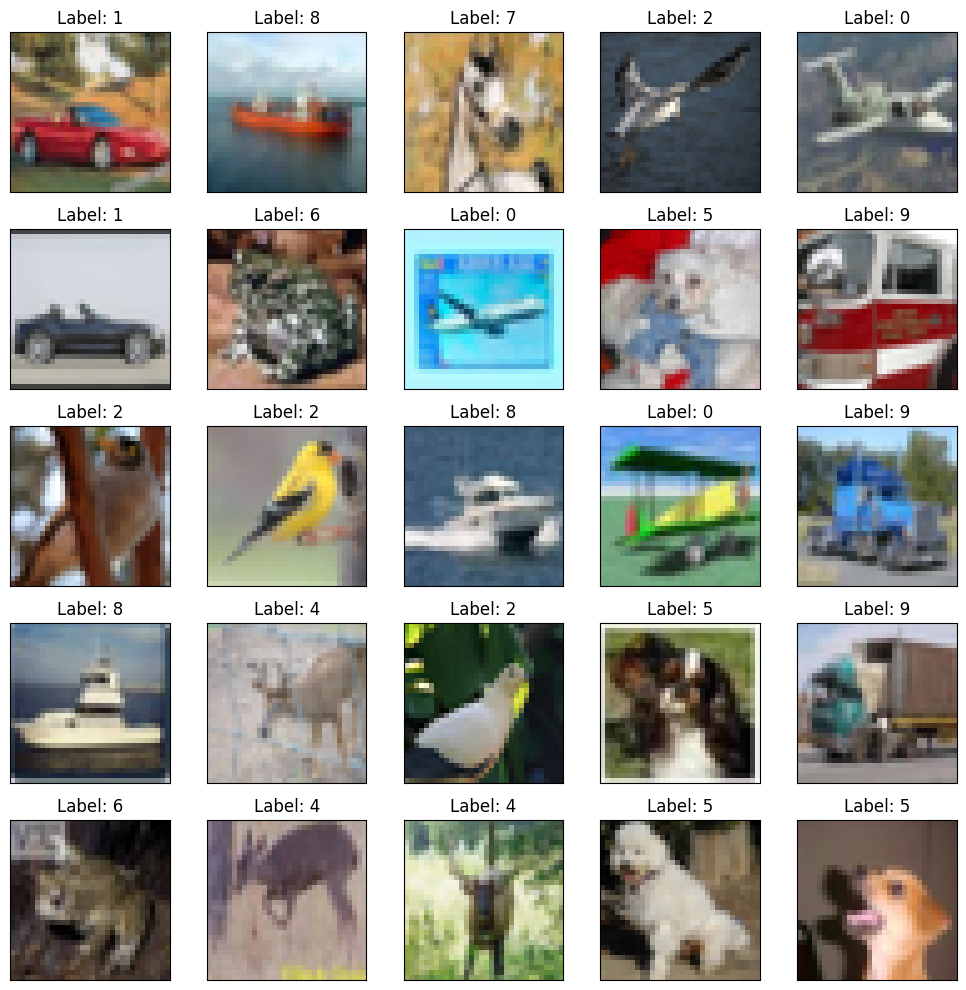

In [4]:
fig, axs = plt.subplots(5, 5, figsize=(10,10))
for ax in axs.flatten():
    # random.choice allows to randomly sample from a list-like object (basically anything that can be accessed with an index, like our dataset)
    img, label = random.choice(train_dataset)
    ax.imshow(np.array(img))
    ax.set_title('Label: %d' % label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

In [5]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Set the train transform
train_dataset.transform = train_transform

# Set the test transform
test_dataset.transform = test_transform

In [6]:
m=len(train_dataset)
train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])

batch_size=256

# The dataloaders handle shuffling, batching, etc...
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

## 1 Define Encoder and Decoder classes

In [7]:
test_dataset.data.shape

(10000, 32, 32, 3)

In [40]:
# Images are (N, W, H)
B = batch_size                 # Batch size
N = test_dataset.data.shape[0] # Examples
W = test_dataset.data.shape[1] # Width
H = test_dataset.data.shape[2] # Height
C = test_dataset.data.shape[3] # Channels
D = W * H * C                  # Features
classes = 10                   # Label classes

# Input of shape (C, W)

# Filters of shape (C, K)
kernels = 12                   # Number of kernels
K = 3                          # Size of kernels
d = 4                          # Latent dimension

In [56]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        # Input size: [batch, C=3, W=32, H=32]
        # Output size: [batch, C=3, W=32, H=32]

        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            
            nn.Conv2d(3, 12, 4, stride=2, padding=1),            # [batch, 12, 16, 16]
            nn.ReLU(True),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),           # [batch, 24, 8, 8]
            nn.ReLU(True),
			nn.Conv2d(24, 48, 4, stride=2, padding=1),           # [batch, 48, 4, 4]
            nn.ReLU(True),
 			nn.Conv2d(48, 96, 4, stride=2, padding=1),           # [batch, 96, 2, 2]
            nn.ReLU(True),
            )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        ### Linear section
        self.encoder_lin = nn.Sequential(
            
            # First linear layer
            nn.Linear(2 * 2 * 96, 128),
            nn.ReLU(True),
            
            # Second linear layer
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        
        # Apply convolutions
        x = self.encoder_cnn(x)
        
        # Flatten
        x = self.flatten(x)
        
        # Apply linear layers
        x = self.encoder_lin(x)
        return x

In [57]:
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            
            # First linear layer
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            
            # Second linear layer
            nn.Linear(128, 2 * 2 * 96),
            nn.ReLU(True)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(96, 2, 2))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            
            nn.ConvTranspose2d(96, 48, 4, stride=2, padding=1),  # [batch, 48, 4, 4]
            nn.BatchNorm2d(48),
            nn.ReLU(True),
            nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),  # [batch, 24, 8, 8]
            nn.BatchNorm2d(24),
            nn.ReLU(True),
            nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),  # [batch, 12, 16, 16]
            nn.BatchNorm2d(12),
            nn.ReLU(True),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),   # [batch, 3, 32, 32]
        )
        
    def forward(self, x):
        
        # Apply linear layers
        x = self.decoder_lin(x)
        
        # Unflatten
        x = self.unflatten(x)
        
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x

## 2 initialize models, loss and optimizer
*Note that "d" is the size of a latent space*

In [58]:
### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
encoder = Encoder(encoded_space_dim=d,fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=d,fc2_input_dim=128)

In [59]:
summary(encoder, (C, W, H))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 16, 16]             588
              ReLU-2           [-1, 12, 16, 16]               0
            Conv2d-3             [-1, 24, 8, 8]           4,632
              ReLU-4             [-1, 24, 8, 8]               0
            Conv2d-5             [-1, 48, 4, 4]          18,480
              ReLU-6             [-1, 48, 4, 4]               0
            Conv2d-7             [-1, 96, 2, 2]          73,824
              ReLU-8             [-1, 96, 2, 2]               0
           Flatten-9                  [-1, 384]               0
           Linear-10                  [-1, 128]          49,280
             ReLU-11                  [-1, 128]               0
           Linear-12                    [-1, 4]             516
Total params: 147,320
Trainable params: 147,320
Non-trainable params: 0
-------------------------------

In [62]:
coords = list(np.zeros(d))
z = torch.Tensor([coords])
print(z.shape)
summary(decoder, (1, 4))

torch.Size([1, 4])


RuntimeError: unflatten: Provided sizes [96, 2, 2] don't multiply up to the size of dim 1 (1) in the input tensor

In [52]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001 # Learning rate


params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

optim = torch.optim.Adam(params_to_optimize, lr=lr)

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)
print(encoder)
print(decoder)

Selected device: cpu
Encoder(
  (encoder_cnn): Sequential(
    (0): Conv2d(3, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(12, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(24, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): Conv2d(48, 96, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): ReLU(inplace=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder_lin): Sequential(
    (0): Linear(in_features=288, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=4, bias=True)
  )
)
Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=384, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(96, 2, 2))
  (decoder_con

## 3 Train model

In [53]:
im = test_dataset[0][0].unsqueeze(0)
a = im + torch.randn_like(im)*0.3
print(a)

tensor([[[[ 7.6172e-01,  9.6456e-01,  3.9363e-01,  ...,  8.6837e-01,
           -4.0467e-02,  7.5307e-01],
          [ 8.7018e-01,  4.7799e-01,  8.5734e-01,  ...,  7.8995e-01,
            5.8635e-01,  5.8686e-01],
          [ 4.5466e-01,  4.4982e-01,  5.3236e-01,  ...,  3.5576e-01,
            2.7511e-01,  5.1179e-01],
          ...,
          [ 3.2823e-01,  1.6633e-01,  1.0672e-01,  ..., -9.8079e-02,
            3.2098e-01,  3.5706e-01],
          [ 9.6273e-02,  2.5218e-01, -2.1052e-01,  ...,  4.4118e-01,
           -2.8158e-01,  1.5879e-01],
          [ 1.9668e-01,  5.1368e-01,  9.6030e-02,  ...,  2.6060e-01,
           -3.5780e-02,  1.7209e-01]],

         [[ 2.5917e-01,  3.6391e-01,  2.5674e-01,  ...,  7.8514e-04,
            4.6598e-01,  1.6626e-01],
          [ 3.2778e-01,  4.7397e-01,  9.9944e-01,  ...,  5.9167e-01,
           -2.2684e-01,  2.9584e-01],
          [ 4.5065e-01,  1.2800e-01,  2.3137e-01,  ..., -1.1142e-01,
            6.9230e-01,  2.8068e-01],
          ...,
     

In [54]:
b = torch.clip(a,0.,1.)
print(b)

tensor([[[[7.6172e-01, 9.6456e-01, 3.9363e-01,  ..., 8.6837e-01,
           0.0000e+00, 7.5307e-01],
          [8.7018e-01, 4.7799e-01, 8.5734e-01,  ..., 7.8995e-01,
           5.8635e-01, 5.8686e-01],
          [4.5466e-01, 4.4982e-01, 5.3236e-01,  ..., 3.5576e-01,
           2.7511e-01, 5.1179e-01],
          ...,
          [3.2823e-01, 1.6633e-01, 1.0672e-01,  ..., 0.0000e+00,
           3.2098e-01, 3.5706e-01],
          [9.6273e-02, 2.5218e-01, 0.0000e+00,  ..., 4.4118e-01,
           0.0000e+00, 1.5879e-01],
          [1.9668e-01, 5.1368e-01, 9.6030e-02,  ..., 2.6060e-01,
           0.0000e+00, 1.7209e-01]],

         [[2.5917e-01, 3.6391e-01, 2.5674e-01,  ..., 7.8514e-04,
           4.6598e-01, 1.6626e-01],
          [3.2778e-01, 4.7397e-01, 9.9944e-01,  ..., 5.9167e-01,
           0.0000e+00, 2.9584e-01],
          [4.5065e-01, 1.2800e-01, 2.3137e-01,  ..., 0.0000e+00,
           6.9230e-01, 2.8068e-01],
          ...,
          [0.0000e+00, 1.4728e-01, 0.0000e+00,  ..., 6.7970

In [55]:
def add_noise(inputs,noise_factor=0.3):
     noise = inputs+torch.randn_like(inputs)*noise_factor
     noise = torch.clip(noise,0.,1.)
     return noise

In [56]:
### Training function
def train_epoch_den(encoder, decoder, device, dataloader, loss_fn, optimizer, noise_factor=0.3):
    
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader:
        
        # Move tensor to the proper device
        image_noisy = add_noise(image_batch,noise_factor)
        image_noisy = image_noisy.to(device)    
        
        # Encode data
        encoded_data = encoder(image_noisy)
        
        # Decode data
        decoded_data = decoder(encoded_data)
        
        # Evaluate loss
        loss = loss_fn(decoded_data, image_noisy)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [57]:
### Testing function
def test_epoch_den(encoder, decoder, device, dataloader, loss_fn,noise_factor=0.3):
    
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    
    with torch.no_grad(): # No need to track the gradients
        
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        
        for image_batch, _ in dataloader:
            
            # Move tensor to the proper device
            image_noisy = add_noise(image_batch,noise_factor)
            image_noisy = image_noisy.to(device)
            
            # Encode data
            encoded_data = encoder(image_noisy)
            
            # Decode data
            decoded_data = decoder(encoded_data)
            
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
            
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
        
    return val_loss.data

In [58]:
def plot_ae_outputs_den(encoder,decoder,n=5,noise_factor=0.3):
    plt.figure(figsize=(10,4.5))
    for i in range(n):

        ax = plt.subplot(3,n,i+1)
        img = test_dataset[i][0].unsqueeze(0)
        image_noisy = add_noise(img,noise_factor)     
        image_noisy = image_noisy.to(device)

        encoder.eval()
        decoder.eval()

        with torch.no_grad():
            rec_img  = decoder(encoder(image_noisy))

        plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('Original images')
            
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(image_noisy.cpu().squeeze().numpy(), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('Corrupted images')

        ax = plt.subplot(3, n, i + 1 + n + n)
        plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('Reconstructed images')
            
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.7, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.3)     
    plt.show()   

In [59]:
### Training cycle
noise_factor = 0.3
num_epochs = 30
history_da={'train_loss':[],'val_loss':[]}

for epoch in range(num_epochs):
    print('EPOCH %d/%d' % (epoch + 1, num_epochs))
    
    ### Training (use the training function)
    train_loss=train_epoch_den(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=train_loader, 
        loss_fn=loss_fn, 
        optimizer=optim,noise_factor=noise_factor)
    
    ### Validation  (use the testing function)
    val_loss = test_epoch_den(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=valid_loader, 
        loss_fn=loss_fn,noise_factor=noise_factor)
    
    # Print Validationloss
    history_da['train_loss'].append(train_loss)
    history_da['val_loss'].append(val_loss)
    print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
    plot_ae_outputs_den(encoder,decoder,noise_factor=noise_factor)


EPOCH 1/30


RuntimeError: mat1 and mat2 shapes cannot be multiplied (256x384 and 288x128)

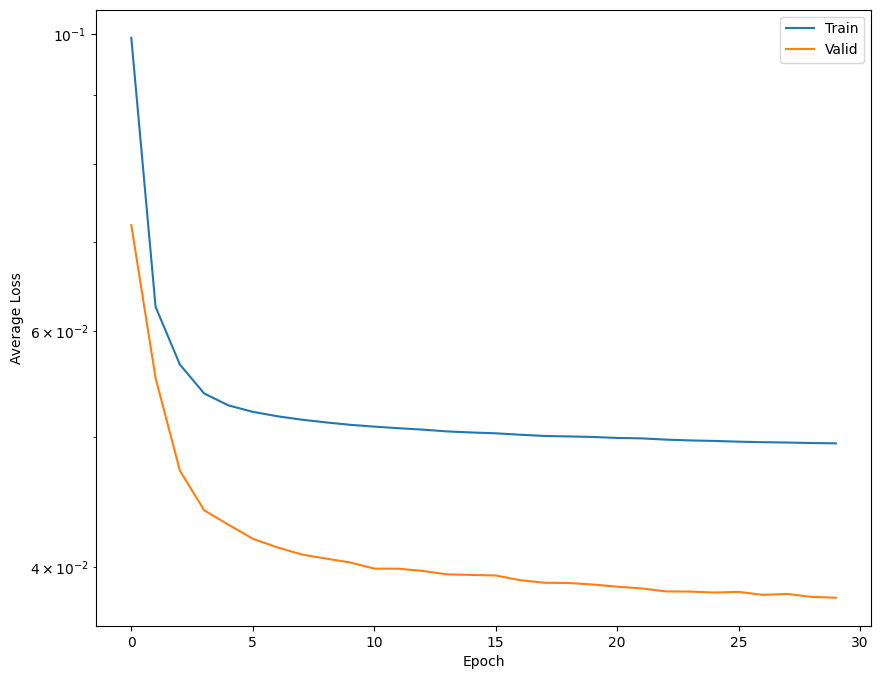

In [18]:
# Plot training performance
test_epoch_den(encoder,decoder,device,test_loader,loss_fn).item()# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(history_da['train_loss'], label='Train')
plt.semilogy(history_da['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.show()

## 4 Visualize latent space

100%|███████████████████████████████████| 10000/10000 [00:05<00:00, 1972.74it/s]


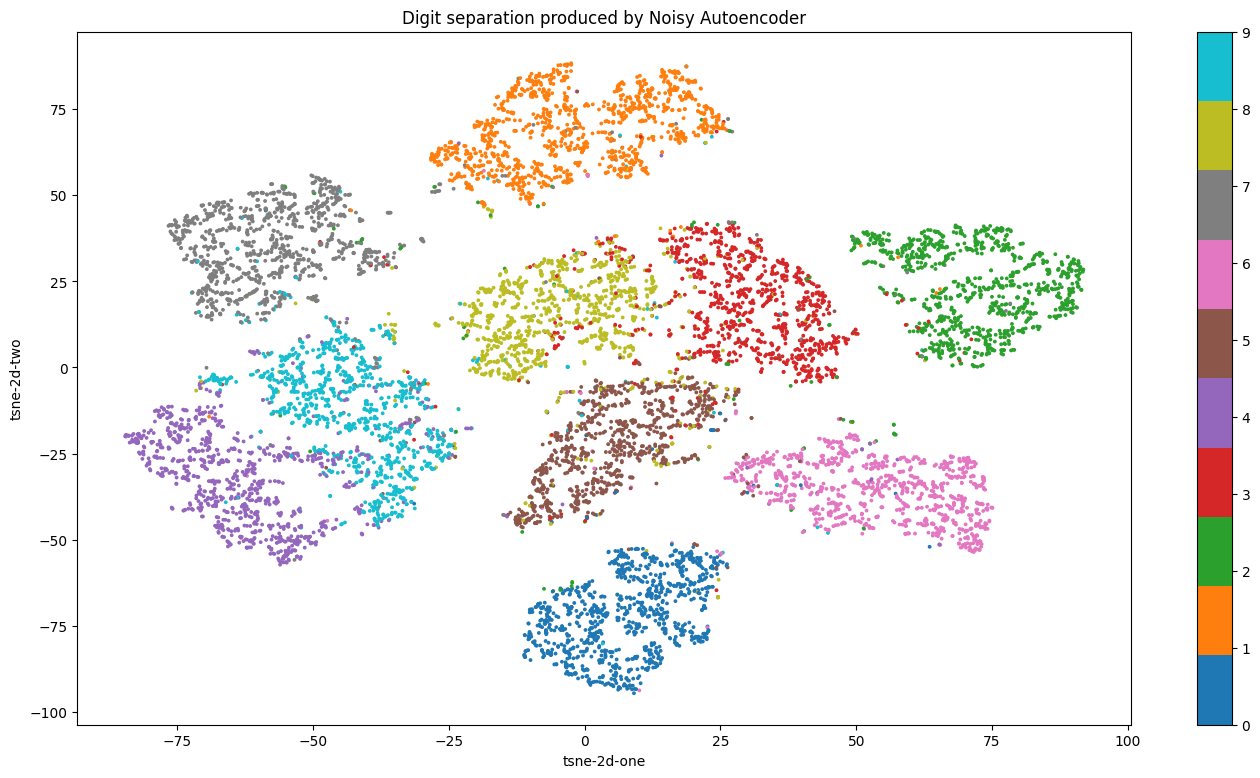

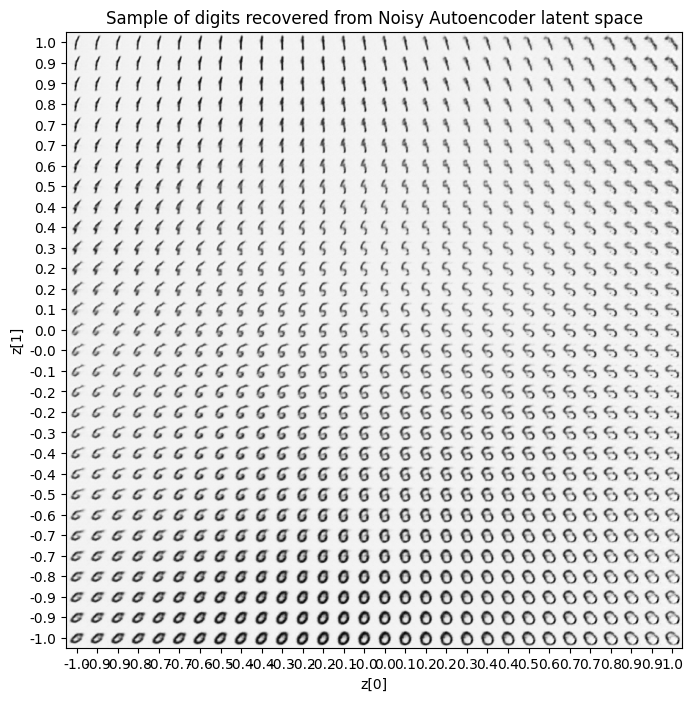

In [19]:
def plot_results(encoder, decoder, data, rx=(-5, 5), ry=(-5, 5), model_name='VAE'):

    # Encode all data samples
    encoded_samples = []
    for sample in tqdm(data):
        
        # Separate image data from its label 
        img = sample[0].unsqueeze(0).to(device)
        label = sample[1]
        
        # Encode image
        encoder.eval()
        with torch.no_grad():
            encoded_img  = encoder(img)
        
        # Append to list
        encoded_img = encoded_img.flatten().cpu().numpy()
        encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
        encoded_sample['label'] = label
        encoded_samples.append(encoded_sample)
        
        # Find latend dimension from decoded image
        latent_dim = len(encoded_img)
        
    encoded_samples = pd.DataFrame(encoded_samples)

    # Create a TSNE model and plot it
    tsne = TSNE(n_components=2)
    tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))
    
    plt.figure(figsize=(17, 9))
    plt.scatter(tsne_results[:,0], tsne_results[:,1], c=encoded_samples.label, cmap='tab10', s=3)
    plt.xlabel('tsne-2d-one')
    plt.ylabel('tsne-2d-two')
    plt.title(f'Digit separation produced by {model_name}')
    plt.colorbar()
    plt.show()
    
    # Prepare a n x n 2D matrix of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    
    # Create a linearly spaced coordinates of 2D digit classes in latent space
    grid_x = np.linspace(*rx, n)
    grid_y = np.linspace(*ry, n)[::-1]

    # Populate the matrix with images decoded from latent space
    for i, yi in enumerate(grid_y):
        for j, xj in enumerate(grid_x):
            # coords = [xj, yi, 0, 0] # Use latent_dim
            coords = list(np.zeros(latent_dim))
            coords[0] = xj
            coords[1] = yi
            z = torch.Tensor([coords]).to(device)
            x_hat = decoder(z)
            digit = x_hat.reshape(digit_size, digit_size).to('cpu').detach().numpy()
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    # Plot the matrix of "fake" sample digits
    plt.figure(figsize=(8, 8))
    start_range = digit_size // 2
    end_range = (n - 1) * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.title(f'Sample of digits recovered from {model_name} latent space')
    plt.imshow(figure, cmap='Greys')
    # plt.savefig(filename)
    plt.show()

plot_results(encoder, decoder, test_dataset, rx=(-1, 1), ry=(-1, 1), model_name="Noisy Autoencoder")

In [20]:
import qiskit.tools.jupyter
%qiskit_version_table